In [1]:
import pickle
import pandas as pd
import polars as pl

import warnings
warnings.filterwarnings('ignore')

from concurrent.futures import ProcessPoolExecutor, as_completed
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

import numpy as np
import minisom
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
kdprov='32'

In [3]:
# Parameters
kdprov = 94


In [4]:
print('===============================================')
print('READ THE DATA')
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/training_VH.pkl','rb') as file:
    df_training_vh=pickle.load(file)
print('FINISH LOAD DATA')

READ THE DATA
FINISH LOAD DATA


In [5]:
df_training_vh.head(2)

idpoint,idsubsegment,idsegment,nth,periode,observation,class,MGRS,VH_30,VH_29,VH_28,VH_27,VH_26,VH_25,VH_24,VH_23,VH_22,VH_21,VH_20,VH_19,VH_18,VH_17,VH_16,VH_15,VH_14,VH_13,VH_12,VH_11,VH_10,VH_9,VH_8,VH_7,VH_6,VH_5,VH_4,VH_3,VH_2,VH_1,VH_0,idkabkota,cluster_data,Sigma0VH_variance
str,str,str,i64,str,i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,f64
"""942601104A1#01""","""942601104A1""","""942601104""",1,"""2022_03""",6,"""NP""","""53MPT""",-16.327053,-16.658817,-16.952844,-17.167469,-17.831659,-16.958177,-16.257051,-16.389317,-15.799401,-15.993532,-15.546324,-15.070858,-15.947469,-14.471731,-12.957722,-14.067765,-14.278798,-14.382627,-14.744373,-15.149094,-15.362589,-15.678154,-15.921735,-15.547118,-15.41563,-15.072829,-14.607827,-14.492457,-14.317425,-13.701499,-13.998955,"""9426""",0,0.866393
"""942601104A1#02""","""942601104A1""","""942601104""",1,"""2022_03""",6,"""NP""","""53MPT""",-15.637659,-16.533747,-16.052196,-15.948635,-16.206579,-15.725562,-15.786127,-14.546646,-14.530822,-15.380964,-15.097027,-15.137781,-15.881493,-14.384003,-13.343065,-13.674299,-12.279093,-14.745687,-13.984944,-14.136473,-14.441362,-14.58291,-15.037954,-14.744455,-14.964971,-14.439731,-13.774549,-14.085353,-13.849115,-14.391888,-13.901679,"""9426""",0,0.866393


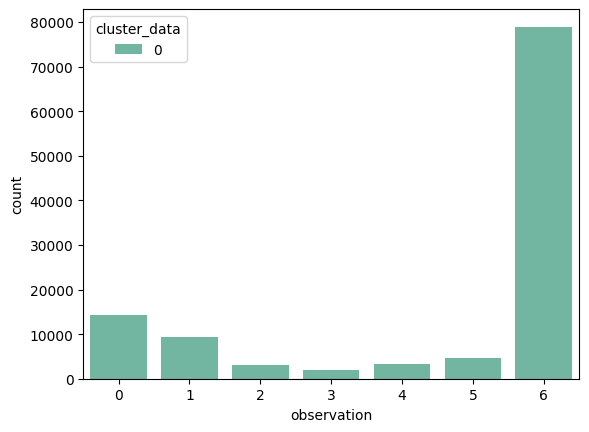

In [6]:
ls_col=['idpoint','nth','observation','periode','idsubsegment','idsegment','cluster_data']
VH_=[f'VH_{30-i}' for i in range(0,31)]
ls_col.extend(VH_)

sns.countplot(x='observation', hue='cluster_data', data=df_training_vh.to_pandas(),palette=sns.color_palette("Set2"))
# Step 4: Show the plot
plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distplot_data_.png", dpi=300, bbox_inches='tight')
plt.show()

In [7]:
## Applying the cluster !
dict_som={}
for cl in df_training_vh.to_pandas().cluster_data.unique():
    print('Running For Cluster:',cl)
    pl_cl=df_training_vh.filter(pl.col('cluster_data')==cl).select(VH_).to_numpy()
    print(pl_cl.shape)
    print('RUN SOM WITH EUCLIDEANS DISTANCE BASED')
    m_neurons = 20
    n_neurons = 20
    som = minisom.MiniSom(n_neurons, m_neurons, pl_cl.shape[1], sigma=1, 
                      learning_rate=.05, random_seed=1234)
    som.random_weights_init(pl_cl)
    som.train_batch(pl_cl, 1000, verbose=True) 
    dict_som[str(cl)]={'som_model':som}#,'means':means,'stds':stds}

Running For Cluster: 0
(115425, 31)
RUN SOM WITH EUCLIDEANS DISTANCE BASED
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 5.892718475306921


 [ 1000 / 1000 ] 100% - 0:00:00 left 


 quantization error: 4.464289681749279
Running For Cluster: 2
(90825, 31)
RUN SOM WITH EUCLIDEANS DISTANCE BASED
 [  264 / 1000 ]  26% - 0:00:00 left 

 [ 1000 / 1000 ] 100% - 0:00:00 left 


 quantization error: 6.161927405004421


In [8]:
from tqdm import tqdm
clusters = df_training_vh.to_pandas().cluster_data.unique()
pl_cl_after_som=pl.DataFrame()
dict_winner={}
for cl in clusters:
    print('Running For Cluster:', cl)
    pl_cl = df_training_vh.filter(pl.col('cluster_data') == cl)
    pl_cl_n=pl_cl.select(VH_).to_numpy()
    winner_a = []
    for index, row in tqdm(enumerate(pl_cl_n)):
        a = dict_som[str(cl)]['som_model'].winner(row)
        winner_a.append(f'R{a[0]}C{a[1]}')
    df_=pl_cl.to_pandas()
    df_['winner']=winner_a
    dict_winner[str(cl)]={'winner':df_}

Running For Cluster: 0


115425it [00:06, 17931.07it/s]


10009it [00:01, 7322.02it/s]

11272it [00:01, 5860.98it/s]

12782it [00:01, 7268.71it/s]

14273it [00:02, 5261.96it/s]

15936it [00:02, 6792.59it/s]

17717it [00:02, 8569.76it/s]

19045it [00:02, 6254.04it/s]

20749it [00:02, 7875.77it/s]

21985it [00:03, 6027.59it/s]

23688it [00:03, 7671.18it/s]

24050it [00:03, 7007.62it/s]

Running For Cluster: 2


0it [00:00, ?it/s]

1786it [00:00, 17851.63it/s]

3572it [00:00, 6137.01it/s] 

4710it [00:00, 5738.23it/s]

6362it [00:00, 7901.98it/s]

8090it [00:00, 9991.48it/s]

9427it [00:01, 5499.61it/s]

11155it [00:01, 7258.56it/s]

12861it [00:01, 5881.41it/s]

14618it [00:02, 7531.86it/s]

15837it [00:02, 5436.64it/s]

17582it [00:02, 7064.76it/s]

19235it [00:02, 8600.28it/s]

20559it [00:02, 7029.39it/s]

22227it [00:03, 8633.84it/s]

23473it [00:03, 5306.08it/s]

25191it [00:03, 6901.99it/s]

26625it [00:03, 5828.15it/s]

27999it [00:04, 6951.63it/s]

29669it [00:04, 8595.68it/s]

30924it [00:04, 5308.07it/s]

32661it [00:04, 6947.11it/s]

34380it [00:04, 8611.78it/s]

35729it [00:05, 6666.43it/s]

37427it [00:05, 8300.56it/s]

38979it [00:05, 5929.05it/s]

40640it [00:05, 7420.43it/s]

42227it [00:05, 8824.70it/s]

43535it [00:06, 6009.21it/s]

45132it [00:06, 7462.51it/s]

46318it [00:06, 5016.42it/s]

48070it [00:07, 6650.88it/s]

49814it [00:07, 8348.08it/s]

51149it [00:07, 6318.12it/s]

52914it [00:07, 8036.04it/s]

54439it [00:08, 4968.54it/s]

56151it [00:08, 6419.23it/s]

57913it [00:08, 8051.17it/s]

59272it [00:08, 6891.07it/s]

61029it [00:08, 8583.20it/s]

62325it [00:09, 5854.98it/s]

64108it [00:09, 7545.82it/s]

65860it [00:09, 9219.77it/s]

67249it [00:09, 6164.14it/s]

68940it [00:09, 7711.41it/s]

70196it [00:10, 6013.53it/s]

71924it [00:10, 7663.40it/s]

73687it [00:10, 9388.14it/s]

75063it [00:11, 4814.15it/s]

76088it [00:11, 5246.01it/s]

77428it [00:11, 6378.25it/s]

78805it [00:11, 7601.24it/s]

80151it [00:11, 8720.96it/s]

81366it [00:11, 5725.14it/s]

82761it [00:12, 7012.42it/s]

83838it [00:12, 5863.47it/s]

85310it [00:12, 7331.61it/s]

86363it [00:12, 5153.78it/s]

87965it [00:12, 6791.33it/s]

89410it [00:13, 5687.18it/s]

90274it [00:13, 5062.57it/s]

90825it [00:13, 6705.19it/s]

In [9]:
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/som_and_observation.pkl','wb'):
    dict_={'som':dict_som,
          'winner_observation':dict_winner}

In [10]:
ls_pd=[]
for i in dict_winner.keys():
    a=dict_winner[i]['winner'][['idpoint','idsubsegment','idsegment','periode','observation','cluster_data','winner']]
    ls_pd.append(a)

df_all_winner=pl.from_pandas(pd.concat(ls_pd))

In [11]:
clusters = df_all_winner.to_pandas().cluster_data.unique()
pl_prior=[]
for cl in clusters:
    df_pivot=df_all_winner.filter(pl.col('cluster_data')==cl).to_pandas()\
            .pivot_table(
            values='idpoint',
            index='winner',
            columns='observation',
            aggfunc='count')
    df_pivot_prior=df_pivot.div(df_pivot.sum(axis=1), axis=0).reset_index()\
            .melt(id_vars="winner", var_name="observation", value_name="prior")
    df_pivot_prior['cluster_data']=cl
    pl_prior.append(df_pivot_prior)
pl_prior=pl.from_pandas(pd.concat(pl_prior))

In [12]:
df_all_winner=df_all_winner.join(pl_prior,on=['winner', 'observation', 'cluster_data'])

In [13]:
df_all_winner.shape

(115425, 8)

Cluster  0
Observation 0


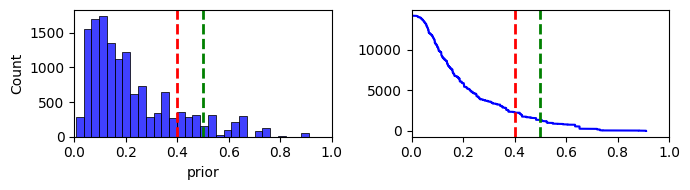

Observation 1


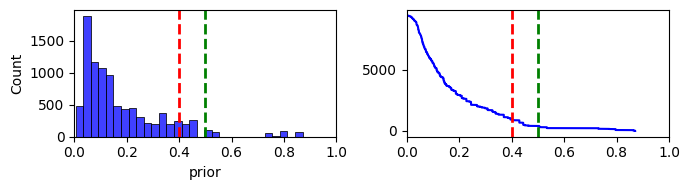

Observation 2


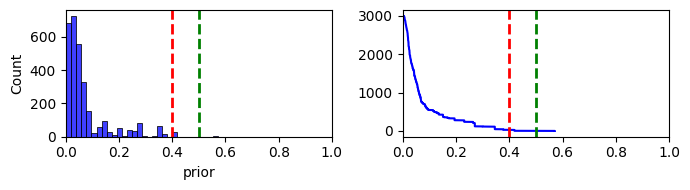

Observation 3


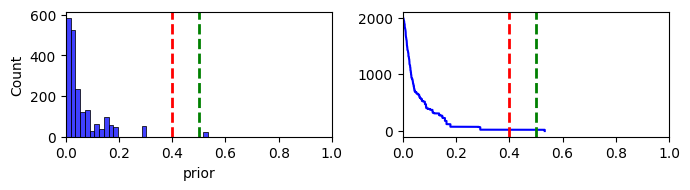

Observation 4


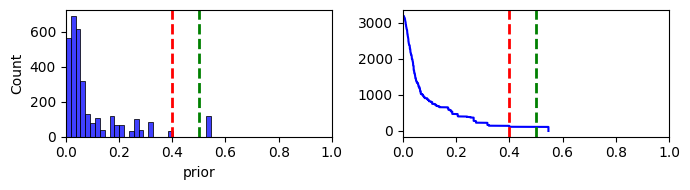

Observation 5


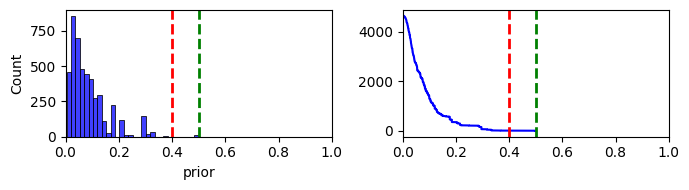

Observation 6


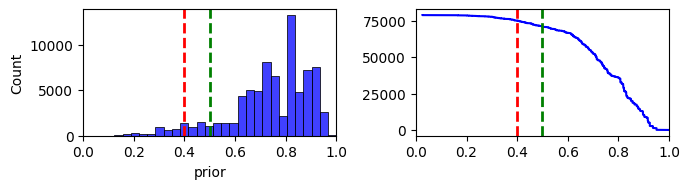

In [14]:
observation = np.sort(df_all_winner.to_pandas().observation.unique())
for cl in np.sort(clusters):
    print('Cluster ',cl)
    for obs in observation:
        print('Observation',obs)
        pl_cl_hist=df_all_winner.filter(pl.col('cluster_data')==cl).filter(pl.col('observation')==obs).to_pandas()
        fig, axs = plt.subplots(1, 2, figsize=(7,2))
        sns.histplot(pl_cl_hist['prior'], bins=30, kde=False, color='blue', edgecolor='black',cumulative=False,ax=axs[0])

        sorted_data = np.sort(pl_cl_hist['prior'])
        cdf = np.arange(1, len(sorted_data) + 1) 
        inverse_cdf = len(sorted_data) - cdf
        axs[1].plot(sorted_data, inverse_cdf, label="Inverse Cumulative", color='blue')

        
        
        #sns.histplot(pl_cl_hist['prior'], cumulative=True, kde=False, stat="density", color="red", 
        #             label="Inverse Cumulative",ax=axs[1])\
        # .lines[-1].set_ydata(
        #     1 - sns.histplot(pl_cl_hist['prior'], cumulative=True, kde=False, stat="density").lines[-1].get_ydata())
        #sns.histplot(pl_cl_hist['prior'], bins=30, kde=False, color='blue', edgecolor='black',cumulative=True,ax=axs[1])
        axs[0].set_xlim(0,1)
        axs[1].set_xlim(0,1)    
        axs[0].axvline(x=0.4,color='red', linestyle='--', linewidth=2)
        axs[0].axvline(x=0.5,color='green', linestyle='--', linewidth=2)
        axs[1].axvline(x=0.4,color='red', linestyle='--', linewidth=2)
        axs[1].axvline(x=0.5,color='green', linestyle='--', linewidth=2)
        plt.tight_layout()
        plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distplot_by_prior_som_{cl}.png", dpi=300, bbox_inches='tight')
        plt.show()

In [15]:
print('pivot_table')
print(df_all_winner.to_pandas().pivot_table(
    values='idpoint',
    columns='observation',
    index='cluster_data',
    aggfunc='count',
    fill_value=0
))

print('filtering_based on prior 0.5')
print(df_all_winner.filter(pl.col('prior')>=0.5).to_pandas().pivot_table(
    values='idpoint',
    columns='observation',
    index='cluster_data',
    aggfunc='count',
    fill_value=0
))


print('filtering_based on prior 0.4')
print(df_all_winner.filter(pl.col('prior')>=0.3).to_pandas().pivot_table(
    values='idpoint',
    columns='observation',
    index='cluster_data',
    aggfunc='count',
    fill_value=0
))

pivot_table
observation       0     1     2     3     4     5      6
cluster_data                                            
0             14225  9400  3000  2000  3200  4650  78950
filtering_based on prior 0.5
observation      0    1  2   3    4   5      6
cluster_data                                  
0             1378  415  4  24  116  15  71300
filtering_based on prior 0.4
observation      0     1    2   3    4   5      6
cluster_data                                     
0             3634  1852  121  24  230  73  77810


In [16]:
df_train_2=[]
for cl in np.sort(clusters):
    for obs in observation:
        dls=[]
        cl_obs=df_all_winner.filter(pl.col('cluster_data')==cl).filter(pl.col('observation')==obs)\
            .filter(pl.col('prior')>=.4)#.to_pandas()
        if cl_obs.shape[0]>=20000:
            cl_obs=cl_obs.sample(20000,with_replacement=False)#.to_pandas()
        dls.append(cl_obs.to_pandas())
        if cl_obs.shape[0]<10000:
            nsample=10000-cl_obs.shape[0]
            cl_tambahan=df_all_winner.filter(pl.col('cluster_data')==cl).filter(pl.col('observation')==obs)\
            .filter(pl.col('prior')<.4)
            if cl_tambahan.shape[0]<nsample:
                cl_tambahan=cl_tambahan.to_pandas()
            else:
                cl_tambahan=cl_tambahan.sample(nsample,with_replacement=False).to_pandas()
            dls.append(cl_tambahan)
        dls=pd.concat(dls)
        df_train_2.append(dls)

In [17]:
df_train_2=pl.from_pandas(pd.concat(df_train_2))

In [18]:
df_train_2.shape

(52250, 8)

In [19]:
#df_train_2=df_train_2.join(df_training_vh,on=['idpoint','idsubsegment','idsegment','periode','observation',
# 'cluster_data'],how='inner')

In [19]:
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/training_VH_v2.pkl','wb') as file:
    pickle.dump(df_train_2,file)

In [20]:
dfx=df_training_vh.to_pandas()
dfy=df_train_2.to_pandas()

In [21]:
u=dfx.merge(dfy).drop_duplicates()

In [22]:
print(u.pivot_table(
    values='idpoint',
    columns='observation',
    index='cluster_data',
    aggfunc='count',
    fill_value=0
))

observation      0     1     2     3     4     5      6
cluster_data                                           
0             7699  5775  1950  1475  2200  2875  17921


In [23]:

with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/training_VH_v2.pkl','wb') as file:
    pickle.dump(u,file)

In [24]:
df_som_pict=df_all_winner.to_pandas().pivot_table(
    index=['cluster_data','winner'],
    columns='observation',
    values='idpoint',
    aggfunc='count'
).fillna(0).reset_index()

In [25]:
df_som_pict

observation,cluster_data,winner,0,1,2,3,4,5,6
0,0,R0C0,11.0,16.0,9.0,29.0,62.0,6.0,62.0
1,0,R0C1,27.0,31.0,8.0,10.0,11.0,24.0,80.0
2,0,R0C10,113.0,63.0,19.0,27.0,21.0,22.0,1498.0
3,0,R0C11,15.0,11.0,9.0,6.0,6.0,3.0,252.0
4,0,R0C12,28.0,10.0,6.0,6.0,11.0,13.0,84.0
...,...,...,...,...,...,...,...,...,...
395,0,R9C5,2.0,4.0,3.0,0.0,0.0,0.0,5.0
396,0,R9C6,9.0,5.0,0.0,0.0,0.0,0.0,126.0
397,0,R9C7,31.0,32.0,10.0,1.0,36.0,5.0,85.0
398,0,R9C8,91.0,106.0,60.0,1.0,26.0,18.0,95.0


Cluster 0


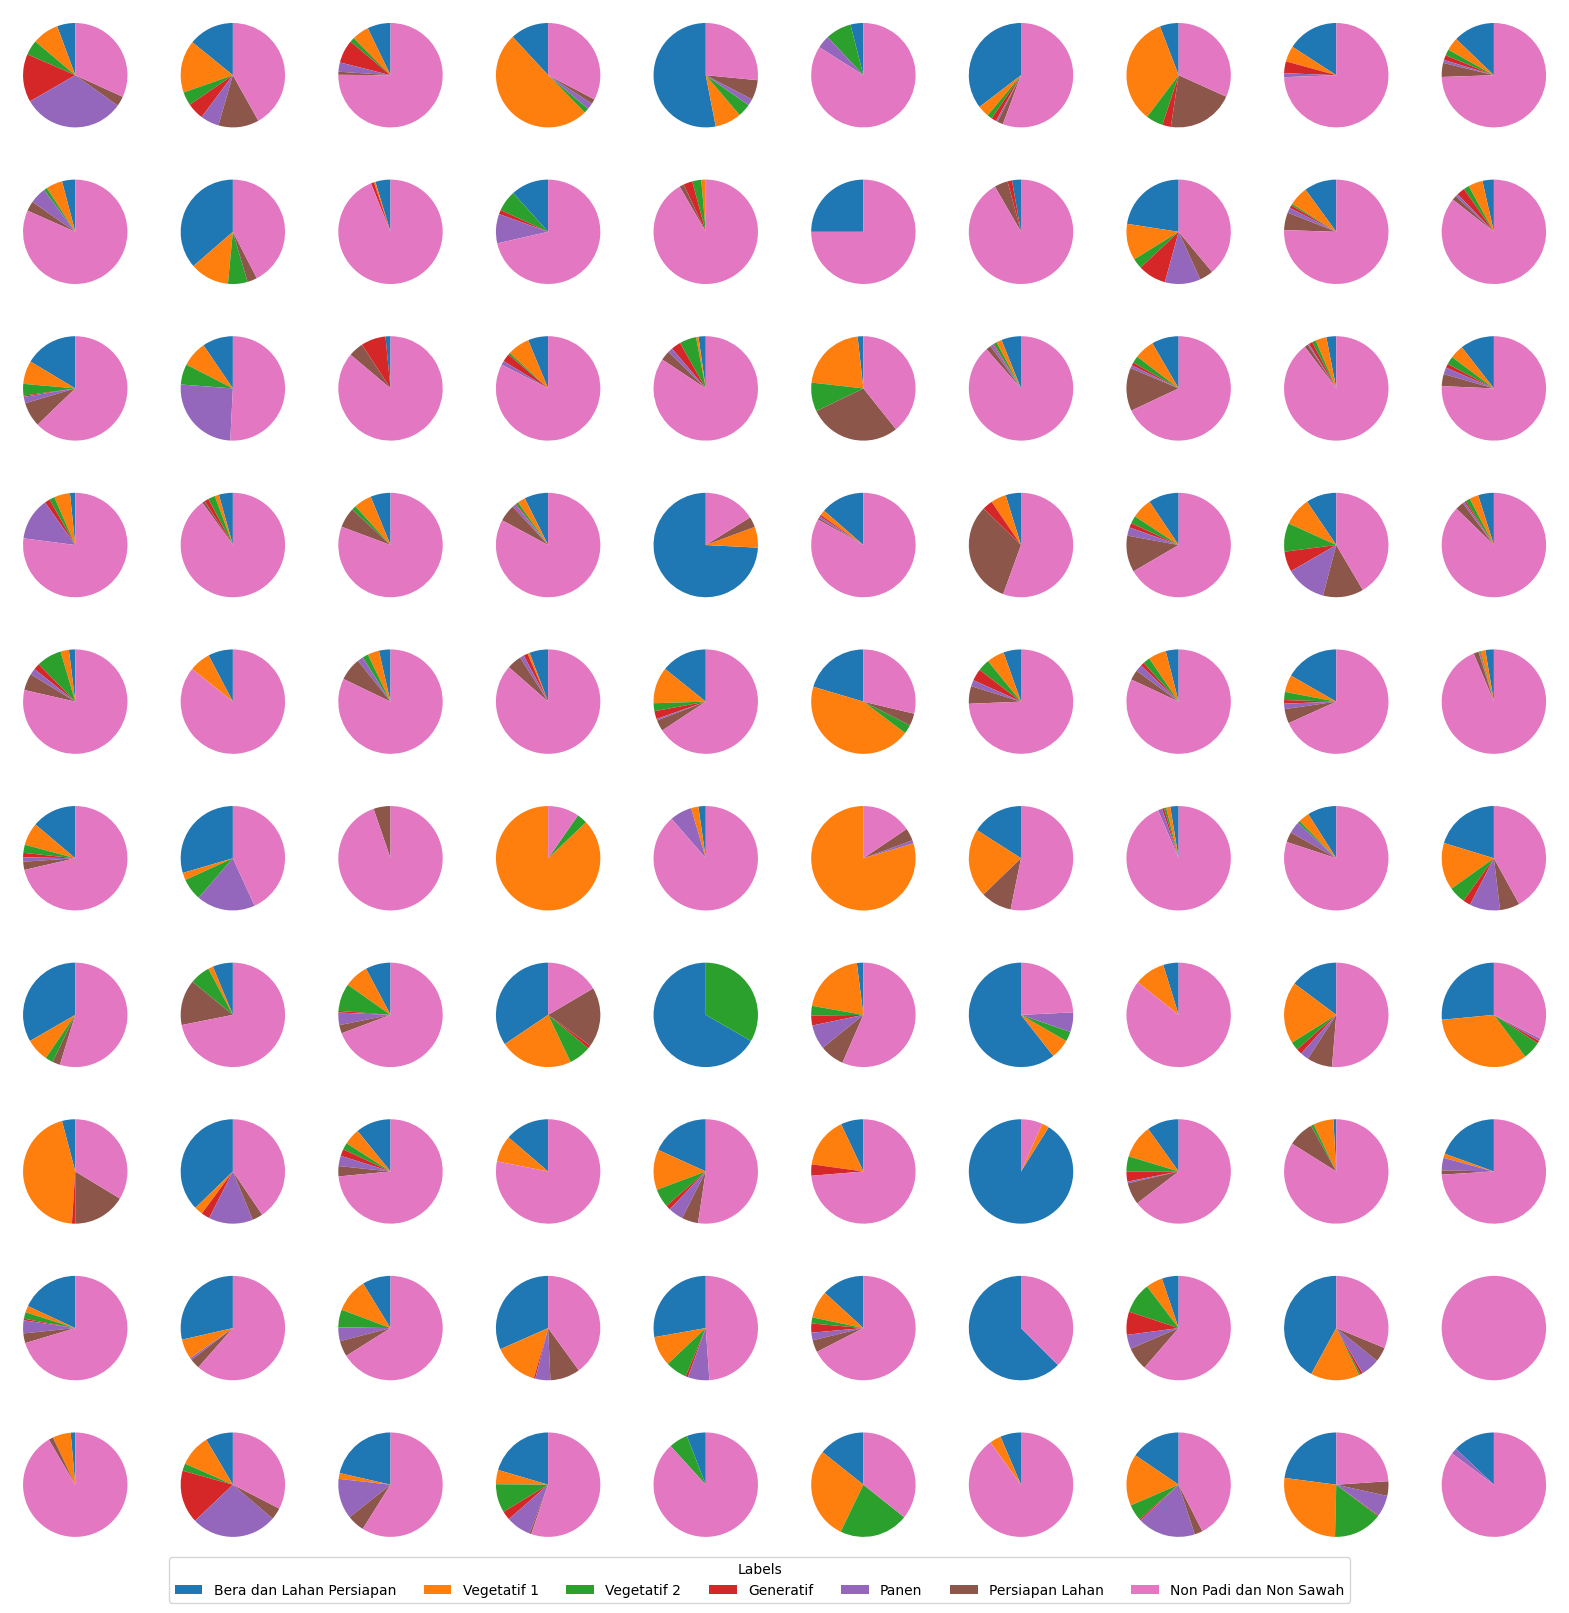

In [26]:
from matplotlib.gridspec import GridSpec

# Assuming df_som_pict and range(7) are defined elsewhere
for cl in df_som_pict['cluster_data'].unique():
    print('Cluster', cl)
    
    # Filter data for the current cluster once outside the loop
    cluster_data = df_som_pict[df_som_pict['cluster_data'] == cl]
    
    fig = plt.figure(figsize=(20, 20))
    gs = GridSpec(10, 10, figure=fig)

    # Precompute all winners to avoid excessive queries
    winners = cluster_data.set_index('winner')

    # Define labels for all pies (the same for all charts)
    pie_labels = np.array(range(7))
    wedges_for_legend = None  # Store wedges for later legend creation

    for i in range(10):
        for j in range(10):
            som_dt = f'R{i}C{j}'
            
            # Use pre-filtered 'winners' DataFrame for the current winner
            if som_dt in winners.index:
                dfx = winners.loc[som_dt]
                
                # Convert to numpy array if necessary, just a single row, no need to query the shape
                data = dfx[range(7)].values
                
                # Plot only if data is non-empty
                if data.size > 0:
                    ax = fig.add_subplot(gs[i, j])
                    
                    # Remove annotation, just plot the pie chart
                    wedges, texts = ax.pie(data, labels=None, startangle=90)
                    
                    # Store the wedges for the first pie chart to use in the global legend
                    if wedges_for_legend is None:
                        wedges_for_legend = wedges

    if wedges_for_legend is not None:
        fig.legend(wedges_for_legend, ['Bera dan Lahan Persiapan','Vegetatif 1','Vegetatif 2','Generatif',
                                      'Panen','Persiapan Lahan','Non Padi dan Non Sawah'], title="Labels", loc="lower center", 
                   bbox_to_anchor=(0.5, 0.08),
                   ncol=len(pie_labels))
    
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distplot_som_neuron_{cl}.png", dpi=300, bbox_inches='tight')
    plt.show()